# Plotting Tool For Fiber Strand Tensile Tests

This tool is for plotting the stress strain curves for tensile tests of carbon fiber strands.

## Importing the necessary packages and defining the work directory 

In the next cell, enter the path for the working directory and choose wanted data files.
The data files might have any extension but have to be in 'csv' format. The first row should contain the names of the data columns.
If not all data files in the directroy need to be plotted, choose the wanted file, then press 'Update file list'.

In [1]:
#%matplotlib inline
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import os
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, Layout,VBox
import ipywidgets as widgets
from IPython.display import display, Javascript
import math
#from sklearn.linear_model import LinearRegression
import csv
from scipy.signal import savgol_filter
#Locale settings
import locale
# Set to German locale to get comma decimal separater
#locale.setlocale(locale.LC_NUMERIC, "de_DE")
#widgets text style
style = {'description_width': 'initial'}

def get_file_list(file_path, section):
    global file_list
    global file_path0
    global section0
    
    file_path0 = file_path
    section0 = section
    # get file list
    file_list = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    #file_list = ['{0}/{1}'.format(file_path, f) for f in listdir(file_path) if isfile(join(file_path, f))]
    file_list = np.sort(file_list)
    if file_list[0] == '.DS_Store':
        file_list = np.delete(file_list, 0)      
        


interact(get_file_list,
         file_path = widgets.Text(value='data/FSZ-Q95-0_1', description='File path', style = style),
         section = widgets.FloatText(value=3.62, description='Sectional Area [mm2]', style = style)
        )    


# def select_files(file_list):
def select_files(file_list):
    checkboxes = [widgets.Checkbox(value=False, description=label, style = style) for label in file_list]
    output = widgets.VBox(children=checkboxes)
    display(output)
    return(checkboxes)

# update
def update_list(t):
    global file_list
    file_list = []
    for i in range(0, len(checkboxes)):
        if checkboxes[i].value == True:
            file_list = file_list + [checkboxes[i].description]
    print(file_list)
    
checkboxes = select_files(file_list)        
button = Button(description="Update file list")
display(button)
button.on_click(update_list)

interactive(children=(Text(value='data/FSZ-Q95-0_1', description='File path', style=DescriptionStyle(descripti…

## Average Tensile Strength

The E-modulus is to be calculated for each test between 10% and 60% of the average tensile strength of the series.
Therefore, the average tensile strength needs to be calculated first for the serie.

In [14]:
# Delect the delimiter from the csv files
def get_delimiter(file_path, bytes = 4096):
    sniffer = csv.Sniffer()
    data = open(file_path, "r").read(bytes)
    delimiter = sniffer.sniff(data).delimiter
    return delimiter

def cala_avg_breaking_load(file_list):
    max_kraft = []
    
    
    for i in range(0,len(file_list)):
        
        f = file_path0 + '/' + file_list[i]
        
        #retrieve the delimiter
        delimiter = get_delimiter(f)
        
        #import data array to be plotted
        data_array = pd.read_table(f,skiprows=range(1,3), delimiter=delimiter, decimal=',')

        #move force to origin point
#         data_array['Kraft'] = data_array['Kraft'] - data_array['Kraft'][0]
        if np.mean(data_array['Kraft'][:int(np.floor(len(data_array)/2))]) < 0:
            data_array['Kraft'] = -data_array['Kraft']
        if np.mean(data_array['DD1'][:int(np.floor(len(data_array)/2))]) < 0:
             data_array['DD1'] = -data_array['DD1']                
            
        #print(max(data_array['Kraft']))
        max_kraft.append(max(data_array['Kraft']))
        
        
    return(max_kraft)

max_kraft = cala_avg_breaking_load(file_list)
mittel_bruchkraft = np.mean(max_kraft)
print('Average Breaking Load is')
print(np.round(mittel_bruchkraft,2))
plot_range_list = np.zeros(len(file_list))
final_table = np.zeros((len(file_list),10))

f = file_path0 + '/' + file_list[-1]
print(max_kraft)

Average Breaking Load is
13.99
[13.31448, 14.15666, 15.4509, 11.41232, 14.51301, 15.20222, 15.26193, 13.13657, 15.33593, 15.19, 14.75, 12.67, 14.26, 15.98, 12.23, 12.04, 13.21, 13.76]


[  3   4  16  17  20  21  38  40  41  42  52  53  54  55  65  66  73  74
  91  92  93  94 103 116 130 133 139 154 166 167 168 190 191 193 194 195
 196 201 204 205 206 216 217 228 230 231 253 254 261 264 266 278 289 290
 291 292 296 297 302 303 304 305 312 313 315 316 317 318 328 330 334 335
 336 340 341 342 352 356 365 366 378 379 382 390 391 402 412 423 426 440
 441 444 450 454 455 460 461 462 466 471 472 480 481 482 491 492 504 505
 507 511 514 516 527 528 535 540 542 543 545 546 547 548 549 550 552 553
 554 555 557 578 613 622 623 626 628 629 630 631 636 637 640 644 645 651
 652 653 659 665 693]
[False  True False False False  True False False False  True False False
 False  True False  True False  True False False False  True  True  True
 False  True  True  True False False  True False False False False False
  True False False False  True False  True False False  True False  True
 False False  True  True False False False  True False  True False False
 False  True False False Fals

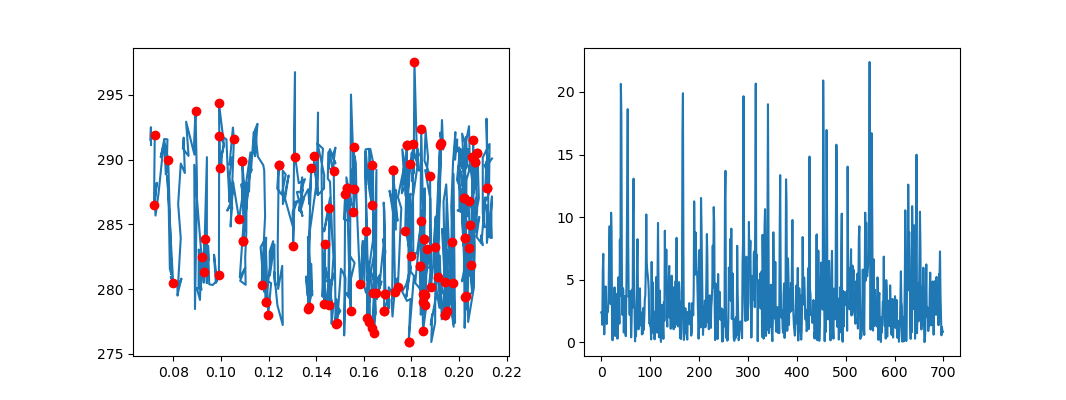

In [15]:
f = file_path0 + '/' + file_list[1]

#retrieve the delimiter
delimiter = get_delimiter(f)

#import data array to be plotted
data_array = pd.read_table(f,skiprows=range(1,3), delimiter=delimiter, decimal=',')


def iron(vals, i):
    vals_2 = np.array(data_array['Kraft'])[:700]    
    for i in range(0,i):
        window = 3
        der2 = savgol_filter(vals, window_length=window, polyorder=2, deriv=2)
        max_der2 = np.max(np.abs(der2))
        der3 = np.c_[np.arange(0,len(der2)),np.abs(der2)]
        der3 = der3[der3[:, 1].argsort()]       
#         large = der3[der3[:,1]> max_der2/3,0]
        large = np.where(np.abs(der2) > 0.25*max_der2)[0]
        print(large)
        gaps = np.diff(large) > window
        print(gaps)
        begins = np.insert(large[1:][gaps], 0, large[0])
        ends = np.append(large[:-1][gaps], large[-1])
        changes = ((begins+ends)/2).astype(int)
        # plt.plot(test_array)
        # plt.plot(changes, test_array[changes], 'ro')
#         vals[ends[0]:] =  vals[ends[0]:] - (vals[ends[0]] - vals[begins[0]])
#         vals = np.delete(vals, range(begins[0],ends[0]))
#         vals_2 = np.delete(vals_2, range(begins[3],ends[3]))
    fig1, (ax1, ax2) = plt.subplots(1, 2,figsize=(16/1.5, 6/1.5))
    ax1.plot(np.array(data_array['DD1'])[:700], np.array(-1000*data_array['Kraft']/1.81)[:700])
    ax1.plot(np.array(data_array['DD1'])[ends], np.array(-1000*data_array['Kraft']/1.81)[ends], 'ro')
    ax1.plot(np.array(data_array['DD1'])[begins], np.array(-1000*data_array['Kraft']/1.81)[begins], 'ro')    
    ax2.plot(np.abs(der2))
#     ax2.plot(vals,vals_2)
#     ax1.plot(np.array(data_array['DD1'])[:900], vals)
    for i in range(0,len(begins)):
        print(abs(vals[ends[i]]- vals[begins[i]]))
    
    plt.show()

iron(np.array(-1000*data_array['Kraft']/1.81)[:700],1)


## Defining the needed functions

The functions for importing, processing and plotting the data is defined.
The function 'def_iron' is for detecting discontinuities using the 1D Savitzky–Golay filter in both the x and y directions, using a 2nd order polynomial and second derivative. The size of the window for detecting the discontinuities can be defined and the number of the peaks to be 'ironed'.

In [4]:
# A = np.array([180, 6, 200 , 10, 300, 500, 400])
# ordered_abs_arr = np.argsort(-A)
# ordered_abs_arr = np.argsort(ordered_abs_arr )
# print(ordered_abs_arr)
# max_der2 = np.max(A)
# large = np.where(A > 0.25*max_der2)[0]
# large_ind = ordered_abs_arr[large]
# #large = large[np.argsort(ordered_abs_arr)]
# print(large)
# print(large_ind)
# print(large[np.argsort(large_ind)])

def iron_force_drop(x_vals, y_vals, i, peaks, window):
    begins = []
    ends = []
    begins0 = []
    ends0 = []
    n_del_values = 0
    if i > 0:
        der2 = savgol_filter(y_vals, window_length=window, polyorder=2, deriv=2)
        ordered_abs_arr = np.argsort(np.abs(der2))
        max_der2 = np.max(np.abs(der2))
        large = np.where(np.abs(der2) > 0.25*max_der2)[0]
        large_ind = ordered_abs_arr[large]
        gaps = np.diff(large) > window
        begins0 = np.insert(large[1:][gaps], 0, large[0])
        ends0 = np.append(large[:-1][gaps], large[-1])
        ordered_jumps = np.argsort(-np.abs(y_vals[ends0] - y_vals[begins0]))
        begins = np.append(begins, begins0)
        ends = np.append(ends, ends0)  
        for j in peaks:
            #changes = ((begins0+ends0)/2).astype(int)
            #e_after = (y_vals[ends0[j]+25]-y_vals[ends0[j]])/(x_vals[ends0[j]+25]-x_vals[ends0[j]])
            x_corr = np.argsort(np.abs(y_vals[ends0[j]] - y_vals[:begins0[j]]))[0]
            print(y_vals[x_corr])
            print(x_vals[x_corr])
            #y_vals[ends0[j]:] =  y_vals[ends0[j]:] - (y_vals[ends0[j]] - y_vals[begins0[j]]) + e_after*(x_vals[ends0[j]] - x_vals[begins0[j]])
            x_vals[ends0[j]:] =  x_vals[ends0[j]:] - (x_vals[ends0[j]]-x_vals[x_corr])
            y_vals = np.delete(y_vals, range(begins0[j],ends0[j]))
            x_vals = np.delete(x_vals, range(begins0[j],ends0[j]))
            n_del_values = n_del_values + len(range(begins0[j],ends0[j]))
            ends0 = ends0 - n_del_values
            begins0 = begins0 - n_del_values
    return(x_vals, y_vals, n_del_values, begins, ends)


def iron_dd1_jump(x_vals, y_vals, i, peaks, window):
    begins = []
    ends = []
    begins0 = []
    ends0 = []
    n_del_values = 0
    if i > 0:
        der2 = savgol_filter(y_vals, window_length=window, polyorder=2, deriv=2)
        ordered_abs_arr = np.argsort(np.abs(der2))
        max_der2 = np.max(np.abs(der2))
        large = np.where(np.abs(der2) > 0.1*max_der2)[0]
        large_ind = ordered_abs_arr[large]
        gaps = np.diff(large) > window
        begins0 = np.insert(large[1:][gaps], 0, large[0])
        ends0 = np.append(large[:-1][gaps], large[-1])
        ordered_jumps = np.argsort(-np.abs(y_vals[ends0] - y_vals[begins0]))
        begins = np.append(begins, begins0)
        ends = np.append(ends, ends0)  
        for j in peaks:
            y_corr = np.argsort(np.abs(x_vals[ends0[j]] - x_vals[:begins0[j]]))[0]
            y_vals[ends0[j]:] =  y_vals[ends0[j]:] - (y_vals[ends0[j]]-y_vals[y_corr])
            x_vals = np.delete(x_vals, range(begins0[j],ends0[j]))
            y_vals = np.delete(y_vals, range(begins0[j],ends0[j]))
            n_del_values = n_del_values + len(range(begins0[j],ends0[j]))
            ends0 = ends0 - n_del_values
            begins0 = begins0 - n_del_values
    return(x_vals, y_vals, n_del_values, begins, ends)

def iron_2(x_vals, y_vals, i, j, window):
    begins = 0
    n_del_values = 0
    for i in range(0,i):
        der2 = savgol_filter(y_vals, window_length=window, polyorder=2, deriv=2)
        max_der2 = np.max(np.abs(der2))
        large = np.where(np.abs(der2) > 0.1*max_der2)[0]
        gaps = np.diff(large) > window
        begins = np.insert(large[1:][gaps], 0, large[0])
    return(x_vals, y_vals, n_del_values, begins)


def iron_3(x_vals, y_vals, i, window, max_diff):
    begins = 0
    n_del_values = 0
    der2 = savgol_filter(y_vals, window_length=window, polyorder=2, deriv=2)
    max_der2 = np.max(np.abs(der2))      
    large = np.where(np.abs(der2) > 0.2*max_der2)[0]
    if len(large) > 0:
        gaps = np.diff(large) > window
        begins = np.insert(large[1:][gaps], 0, large[0])
        print(len(begins))
        ends = np.append(large[:-1][gaps], large[-1])
        changes = ((begins+ends)/2).astype(int)
#         print(y_vals[ends]-y_vals[begins])
#         print(x_vals[ends]-x_vals[begins])        
        for i in range(0,len(begins)):
            if abs(y_vals[ends[i]] - y_vals[begins[i]]) > max_diff:
#                 print(max(y_vals))
#                 print(x_vals[begins[i]])
#                 print(x_vals[ends[i]])
#                 print(y_vals[begins[i]])
#                 print(y_vals[ends[i]])  
                e_after = (y_vals[ends[i]+10]-y_vals[ends[i]])/(x_vals[ends[i]+10]-x_vals[ends[i]])
                y_vals[ends[i]:] =  y_vals[ends[i]:] - (y_vals[ends[i]] - y_vals[begins[i]]) + e_after*(x_vals[ends[i]] - x_vals[begins[i]])
                y_vals = np.delete(y_vals, range(begins[i],ends[i]))
                x_vals = np.delete(x_vals, range(begins[i],ends[i]))
                it_del_values = len(range(begins[i],ends[i]))
                ends = ends - it_del_values 
                begins = begins - it_del_values
                n_del_values = n_del_values + it_del_values
            elif i == len(begins) - 1:  
                x_vals = x_vals
                y_vals = y_vals
                begins = []
    else:
        x_vals = x_vals
        y_vals = y_vals
        begins = []
    return(x_vals, y_vals, n_del_values)
        
def import_data(f, c_sect):
    global headers
    global plot_name
    global file_ext

    plot_name = os.path.splitext(f)[0]
    file_ext = os.path.splitext(f)[-1]

    f = '{0}/{1}'.format(file_path0, f)

    #retrieve the delimiter
    delimiter = get_delimiter(f)
    
    #import data array to be plotted
    data = pd.read_table(f,skiprows=range(1,3), delimiter=delimiter, decimal=',')
    original_array = pd.read_table(f,skiprows=range(1,3), delimiter=delimiter, decimal=',')
    
    #import headers of data
    headers = pd.read_csv(f, nrows=1, delimiter=delimiter).columns.tolist()

    #move force to origin point
#     data['Kraft'] = data['Kraft'] - data['Kraft'][0]
#     data_array['Dehnung'] = data_array['Dehnung'] - data_array['Dehnung'][0]


    #reverse negative regime
    if np.mean(data['Kraft'][:int(np.floor(len(data)/2))]) < 0:
        data['Kraft'] = -data['Kraft']
    if np.mean(data['DD1'][:int(np.floor(len(data)/2))]) < 0:
        data['DD1'] = -data['DD1']
    
    #add stress according to cross section
    data['Spannung'] = 1000*data['Kraft']/c_sect
    original_array['Spannung'] = 1000*data['Kraft']/c_sect

    headers.append('Spannung')
    
    plot_min = math.floor(0.1*len(data))
    plot_max = math.floor(len(data))
    plot_step = math.floor(0.01*len(data))
    max_starting_point = math.floor(0.25*len(data))
    
    return(data)

def shift_figure(data_array, x, y, starting_point, data_range):
    reg_X = np.array(data_array[x][starting_point:data_range])
    reg_y = np.array(data_array[y][starting_point:data_range])
    #reg = LinearRegression().fit(reg_X, reg_y)
    A = np.vstack([reg_X, np.ones(len(reg_X))]).T
    reg = np.linalg.lstsq(A, reg_y, rcond=None)[0]
    print(reg)  
    e_mod = reg[0]
    shifting = -reg[1]/reg[0]
    return(shifting)


#plotting function
def plotter(data_array, data_range, starting_point, shifting,
            x, y, units_x, units_y, grid_x_spacing, grid_y_spacing,
            x_ir_iter, y_ir_iter, win_x, win_y, peak_num_x, peak_num_y, autom_ironing):
    global fig1
    global plot_range_list
    global extent
    
    plt.close()
    
    #define save the range of the plot
    plot_range_list[np.array(file_list) == plot_name + '.csv'] = data_range
    
    plt.rcParams["font.family"] = "Arial"
    #fig1 = plt.figure(figsize=(8/2.52, 6/2.52))
    fig1, (ax1, ax2) = plt.subplots(2, 1,figsize=(8/1.75, 12/1.75))
    if shifting:                                        
        shifting = shift_figure(data_array, x, y, starting_point, data_range)
        print(shifting)
    else:
        shifting = 0
        
    x_plot = np.array(data_array[x][starting_point:data_range]) - shifting #- data_array[x][starting_point])
    y_plot = np.array(data_array[y][starting_point:data_range]) #- data_array[y][starting_point]) 
    
    x_begins = []
    y_begins = []
    x_ends = []
    y_ends = []
    

    if autom_ironing == 'True':
        #iron the y values
        # for Q85
#         x_plot, y_plot, n_del_values = iron_3(x_plot, y_plot, 1, 5,  11) 
        # for Q95
        x_plot, y_plot, n_del_values = iron_3(x_plot, y_plot, 1, 5,  51) 
        data_range = data_range - n_del_values 
    else:
        #iron the y values
        x_plot, y_plot, n_del_values, x_begins, x_ends = iron_force_drop(x_plot, y_plot, y_ir_iter, peak_num_y,  win_y)
        data_range = data_range - n_del_values 


        #iron the x values
        y_plot, x_plot, n_del_values, y_begins, y_ends = iron_dd1_jump(y_plot, x_plot, x_ir_iter, peak_num_x, win_x)
        data_range = data_range - n_del_values

    
 
    #plot 
    ax1.plot(x_plot, y_plot, color='black',linewidth=1
            )
    ax2.plot(data_array[x], data_array[y], color='black',linewidth=1
            )    
    
     #formatting ax1
    x_label = r'$\mathbf{Dehnung}$' + r" $\mathbf{{[{0}]}}$".format(units_x)
    y_label = r'$\mathbf{Spannung}$ $\mathbf{\sigma}$'  + r" $\mathbf{{[{0}]}}$".format(units_y)
    ax1.set_xlabel(x_label, fontsize=12)
    ax1.set_ylabel(y_label, fontsize=12)
    ax1.grid(visible='Yes', which='major', axis='both', color='black')

    ax1.set_xticks(np.arange(0, 12+grid_x_spacing/2, grid_x_spacing), fontsize=14)
    ax1.set_yticks(np.arange(0, 3500+grid_y_spacing/2, grid_y_spacing), fontsize=14)
    ax1.set_xlim([0,12]) 
    ax1.set_ylim([0,3500])
    
    #formatting ax2
    o_x_label = r'$\mathbf{{{0}}}$'.format(x) + r" $\mathbf{{[{0}]}}$".format(units_x)
    o_y_label = r'$\mathbf{{{0}}}$'.format(y)  + r" $\mathbf{{[{0}]}}$".format(units_y)    
    ax2.set_xlabel(o_x_label, fontsize=12)
    ax2.set_ylabel(o_y_label, fontsize=12)
    ax2.grid(visible='Yes', which='major', axis='both', color='black')
    
    #plot the gaps
    ax2.plot(data_array[x][x_begins], data_array[y][x_begins], 'ro')
    ax2.plot(data_array[x][x_ends], data_array[y][x_ends], 'ro')    
    ax2.plot(data_array[x][y_begins], data_array[y][y_begins], 'bo')
    ax2.plot(data_array[x][y_ends], data_array[y][y_ends], 'bo')   
    
    
    
#     plt.rcParams['axes.formatter.use_locale'] = True
    
    #get the current file index
    curr_ind = np.where(np.array(file_list) == plot_name + file_ext)

    mittel_bruchspannung = 1000*mittel_bruchkraft/section0
    
    #fill in the values in the table
    ind_60 = np.abs(y_plot - 0.6*mittel_bruchspannung).argmin()

    ind_10 = np.abs(y_plot - 0.1*mittel_bruchspannung).argmin() 
    

    final_table[curr_ind,0] = max(data_array['Kraft'])
    final_table[curr_ind,1] = max(data_array['Spannung'])

    final_table[curr_ind,3] = x_plot[ind_10]
#     final_table[curr_ind,4] = y_plot[ind_10]
    final_table[curr_ind,4] = 0.1 * mittel_bruchspannung

    final_table[curr_ind,6] = x_plot[data_range-starting_point-1]   
    final_table[curr_ind,7] = max(y_plot) / mittel_bruchspannung
    final_table[curr_ind,8] = 0.6 * mittel_bruchspannung


    
    if max(y_plot) > 0.6*mittel_bruchspannung:
        final_table[curr_ind,5] = x_plot[ind_60]
        final_table[curr_ind,9] = (final_table[curr_ind,8] - final_table[curr_ind,4])/(final_table[curr_ind,5] - final_table[curr_ind,3])
    else:
        final_table[curr_ind,9] = (y_plot[data_range-starting_point-1]  - final_table[curr_ind,4]) / (x_plot[data_range-starting_point-1]  - final_table[curr_ind,3])
        final_table[curr_ind,5] = 0     
        
    final_table[curr_ind,2] = final_table[curr_ind,1]/final_table[curr_ind,9]

    #save plot
    plot_array = np.vstack((x_plot,y_plot)).T
    path_to_plots = file_path0 + '/plots_data/'
    if not os.path.exists(path_to_plots):
        os.makedirs(path_to_plots)
        
    np.savetxt(path_to_plots + plot_name + '.txt', plot_array)
    
    #save original plot
    plot_array = np.vstack((data_array[x],data_array[y])).T
    path_to_plots = file_path0 + '/original_plots/'
    if not os.path.exists(path_to_plots):
        os.makedirs(path_to_plots)
        
    np.savetxt(path_to_plots + plot_name + '.txt', plot_array)
    
    
    plt.tight_layout()
    extent = ax1.get_tightbbox(fig1.canvas.get_renderer()).transformed(fig1.dpi_scale_trans.inverted()) 
    extent.y1 = extent.y1 + 0.1
    extent.x1 = extent.x1 + 0.1
    plt.show()

def save_fig_button(t):
    global plot_name
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plot_name = file_path0 + '/' + plot_name + '.png'
    fig1.savefig(plot_name, dpi=1200, bbox_inches=extent)
    
    
    

## Quick plotting 
A plot is produced for every data file in the list, for which the plotting range is automatically detected through the ironing function and a summary table is created that contains key values: <br> 
breaking Load, breaking Stress, breaking strain, stress and strain at 10% of the average breaking load, stress and strain at 60% (if it is in the linear regime) and E-modulus. In case 60% is not reached, the maximum stress and strain of the linear segment is used for calculating the E-modulus.
The plots are saved to the same working directory.
p.s. output is supressed in this cell, use the next cell to save and view then summary table.

In [5]:
%%capture
plot_range = np.zeros(len(file_list)).astype(int)
for i in range(0,len(file_list)):
    data_array = import_data(file_list[i], section0)
 
    _,_,_,plot_def = iron_2(np.array(data_array['DD1']), np.array(data_array['DD1']), 1, 0, 51)
    print(plot_def)
    plot_range[i] = min(plot_def) - 70
    print(plot_range[i])
    print(data_array['Spannung'][plot_range[i]])

    plotter(data_array, plot_range[i], 0,False , 'DD1', 'Spannung', '‰', 'MPa', 2, 500, 0, 0, 0, 0, 0, 0, 'False')

    save_fig_button(0)

In [6]:
final_table = final_table.astype(float)

df = pd.DataFrame(data=final_table, index=file_list, columns=['Bruchkraft', 'Bruchspannung', 'Bruchdehnung',
                                                              '𝞮\u2081\u2080', 'σ\u2081\u2080', '𝞮\u2086\u2080',
                                                              '𝞮\u2097', 'l', 'σ\u2086\u2080', 'E Modul'])
df['Bruchdehnung'] = df['Bruchspannung']/df['E Modul']
df = df.round(2)


df.to_excel(file_path0 + '/' + 'summary' +'.xls')
df

/var/folders/ty/qmvrc38j54nfv92yrb39ybvr0000gn/T/ipykernel_28249/3782440355.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(file_path0 + '/' + 'summary' +'.xls')


,Bruchkraft,Bruchspannung,Bruchdehnung,𝞮₁₀,σ₁₀,𝞮₆₀,𝞮ₗ,l,σ₆₀,E Modul
2021_08_18_FSZ-Q95-90-01.csv,13.79,3808.25,15.55,2.32,382.94,10.13,11.84,0.72,2297.61,244.98
2021_08_18_FSZ-Q95-90-02.csv,13.42,3708.12,9.78,1.95,382.94,7.00,8.46,0.68,2297.61,379.15
2021_08_18_FSZ-Q95-90-03.csv,14.68,4055.35,1.85,1.46,382.94,0.00,2.14,0.49,2297.61,2187.64
2021_08_18_FSZ-Q95-90-04.csv,12.36,3414.55,-0.06,-0.38,382.94,0.00,-0.38,0.04,2297.61,-58353.12
2021_08_18_FSZ-Q95-90-05.csv,12.63,3488.90,4.01,1.05,382.94,3.25,3.54,0.66,2297.61,870.42
FSZ-Q95-90-06.csv,13.52,3735.03,13.40,0.62,382.94,7.49,7.72,0.64,2297.61,278.64
FSZ-Q95-90-07.csv,13.03,3598.27,0.05,0.00,382.94,0.00,0.00,0.07,2297.61,67889.50
FSZ-Q95-90-08.csv,15.74,4348.09,18.20,0.84,382.94,8.86,8.92,0.60,2297.61,238.88
FSZ-Q95-90-09.csv,15.67,4329.97,19.32,0.24,382.94,8.79,9.30,0.63,2297.61,224.14
FSZ-Q95-90-10.csv,13.40,3702.76,16.70,0.54,382.94,9.17,9.48,0.62,2297.61,221.74


## Reviewing Plots
The individual plots can be reviewed and modified here:
- The start of the plot could be shifted using the starting point slider.
- The end of the plot could be changed using the data_range slider.
- The names of the axis can be changed.
- Other plots can be viewed using the drop down menus for the x and y axis.
- The spacing of the grid in both x and y directions can be changed.
- The ironing parameters could be tweeked

Modifying the plot would automatically change the calculated E-modulus in the summary table.

Another plot is produced underneeth the main plot where the original data is plotted for comparison.

In [10]:
def user_plotter(file):

    data = import_data(file, section0)
    
    if 'plot_range' in globals():
        data_range = plot_range[file_list.index(file)]
    else:
        data_range = 0.7 * len(data)

    widget =   interactive(plotter, data_range=widgets.IntSlider(max=len(data), value=data_range, style = style, description='plotting range'),
                     starting_point=widgets.IntSlider(min=0, max=0.25*len(data), value=0, style = style, description='starting point'),
                     shifting = widgets.Checkbox(value=False,description='shift starting point'),
                     x=widgets.Dropdown(options=headers, value=headers[3], style = style),
                     y=widgets.Dropdown(options=headers, value=headers[-1], style = style),
                     units_x = widgets.Text(value='‰', description='x units', style = style),
                     units_y = widgets.Text(value='MPa', description='y units', style = style),
                     grid_x_spacing = widgets.FloatText(value=2, description='grid x spacing', style = style),
                     grid_y_spacing = widgets.FloatText(value=500, description='grid y spacing', style = style, step=250),   
                     x_ir_iter = widgets.IntText(value=0, description='x Ironing Iterations', style = style),
                     y_ir_iter = widgets.IntText(value=0, description='y Ironing Iterations', style = style),
                     win_x = widgets.BoundedIntText(value=5, min = 3, step=2, description='x window size', style = style),
                     win_y = widgets.BoundedIntText(value=5, min = 3, step=2, description='y window size', style = style),
                     data_array = fixed(data),
                     peak_num_x =widgets.SelectMultiple(options=np.arange(0, 20, 1, dtype=int),
                                                           value=[0],
                                                           #rows=10,
                                                           description='peak nums of strain',
                                                  disabled=False),
                     peak_num_y =widgets.SelectMultiple(options=np.arange(0, 20, 1, dtype=int),
                                                           value=[0],
                                                           #rows=10,
                                                           description='peak nums of force',
                                                  disabled=False),                           
                     autom_ironing = fixed('False')
                    )


    
    box_layout = Layout(overflow='scroll hidden',
                        border='3px solid black',
                        width='',
                        height='',
                        flex_flow='column',
                        display='flex')
    #carousel = Box(children=items, layout=box_layout)  
    
    #     controls = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
    controls = HBox(widget.children[:-1], layout = box_layout)    
    output = widget.children[-1]
    display(HBox([controls, output]))
    
interact(user_plotter,
         file=widgets.Dropdown(options=file_list, description='File', value = file_list[0],style = style),
        )



button = Button(description="Savefig")
display(button)

button.on_click(save_fig_button)

interactive(children=(Dropdown(description='File', options=('2021_08_18_FSZ-Q95-90-01.csv', '2021_08_18_FSZ-Q9…

Button(description='Savefig', style=ButtonStyle())

In [11]:
final_table = final_table.astype(float)

df = pd.DataFrame(data=final_table, index=file_list, columns=['Bruchkraft', 'Bruchspannung', 'Bruchdehnung',
                                                              '𝞮\u2081\u2080', 'σ\u2081\u2080', '𝞮\u2086\u2080',
                                                              '𝞮\u2097', 'l', 'σ\u2086\u2080', 'E Modul'])
df['Bruchdehnung'] = df['Bruchspannung']/df['E Modul']
df = df.round(2)


df.to_excel(file_path0 + '/' + 'summary' +'.xls')
df

/var/folders/ty/qmvrc38j54nfv92yrb39ybvr0000gn/T/ipykernel_28249/3782440355.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(file_path0 + '/' + 'summary' +'.xls')


,Bruchkraft,Bruchspannung,Bruchdehnung,𝞮₁₀,σ₁₀,𝞮₆₀,𝞮ₗ,l,σ₆₀,E Modul
2021_08_18_FSZ-Q95-90-01.csv,13.79,3808.25,15.55,2.32,382.94,10.13,11.83,0.72,2297.61,244.98
2021_08_18_FSZ-Q95-90-02.csv,13.42,3708.12,9.78,1.95,382.94,7.00,7.63,0.68,2297.61,379.15
2021_08_18_FSZ-Q95-90-03.csv,14.68,4055.35,11.74,1.46,382.94,0.00,1.56,0.11,2297.61,345.57
2021_08_18_FSZ-Q95-90-04.csv,12.36,3414.55,-0.90,2.49,382.94,1.98,4.51,0.89,2297.61,-3792.64
2021_08_18_FSZ-Q95-90-05.csv,12.63,3488.90,4.01,1.05,382.94,3.25,3.50,0.66,2297.61,870.42
FSZ-Q95-90-06.csv,13.52,3735.03,14.15,0.62,382.94,7.87,8.28,0.64,2297.61,263.92
FSZ-Q95-90-07.csv,13.03,3598.27,22.92,1.81,382.94,0.00,11.98,0.56,2297.61,157.00
FSZ-Q95-90-08.csv,15.74,4348.09,18.20,0.84,382.94,8.86,9.85,0.66,2297.61,238.88
FSZ-Q95-90-09.csv,15.67,4329.97,18.08,0.24,382.94,8.24,9.40,0.68,2297.61,239.47
FSZ-Q95-90-10.csv,13.40,3702.76,14.89,0.54,382.94,8.24,9.28,0.67,2297.61,248.68


In [16]:
interact(get_file_list,
         file_path = widgets.Text(value='data/FSZ-Q95-0_1/plots_data', description='File path', style = style),
         section = widgets.FloatText(value=3.62, description='Sectional Area [mm2]', style = style)
        )    

# reevaluate picking out some of them
checkboxes = select_files(file_list)        
button = Button(description="Update file list")
display(button)
button.on_click(update_list)

interactive(children=(Text(value='data/FSZ-Q95-0_1/plots_data', description='File path', style=DescriptionStyl…

Button(description='Update file list', style=ButtonStyle())

['2021_08_18_FSZ-Q95-0-02.txt', '2021_08_18_FSZ-Q95-0-03.txt', '2021_08_18_FSZ-Q95-0-04.txt', '2021_08_18_FSZ-Q95-0-05.txt', 'FSZ-Q95-0-06.txt', 'FSZ-Q95-0-07.txt', 'FSZ-Q95-0-08.txt', 'FSZ-Q95-0-09.txt', 'FSZ-Q95-0-10.txt', 'FSZ-Q95-0-50_001.txt', 'FSZ-Q95-0-51.txt', 'FSZ-Q95-0-52.txt', 'FSZ-Q95-0-53.txt', 'FSZ-Q95-0-54.txt', 'FSZ-Q95-0-61.txt', 'FSZ-Q95-0-62.txt', 'FSZ-Q95-0-63.txt', 'FSZ-Q95-0-64.txt']
['2021_08_18_FSZ-Q95-0-02.txt', '2021_08_18_FSZ-Q95-0-03.txt', '2021_08_18_FSZ-Q95-0-04.txt', '2021_08_18_FSZ-Q95-0-05.txt', 'FSZ-Q95-0-06.txt', 'FSZ-Q95-0-07.txt', 'FSZ-Q95-0-08.txt', 'FSZ-Q95-0-09.txt', 'FSZ-Q95-0-10.txt', 'FSZ-Q95-0-50_001.txt', 'FSZ-Q95-0-51.txt', 'FSZ-Q95-0-52.txt', 'FSZ-Q95-0-53.txt', 'FSZ-Q95-0-54.txt', 'FSZ-Q95-0-61.txt', 'FSZ-Q95-0-62.txt', 'FSZ-Q95-0-63.txt', 'FSZ-Q95-0-64.txt']


In [19]:
final_table = np.zeros((len(file_list),10))
print(file_list)
for i in range(0,len(file_list)):
    f = file_path0 + '/' + file_list[i]
    plot_data = np.loadtxt(f)
    #fig1, ax1 = plt.subplots(1, 1,figsize=(8/1.75, 6/1.75))
    ind_60 = np.abs(plot_data[:,1] - 600*mittel_bruchkraft/section0).argmin()
    ind_10 = np.abs(plot_data[:,1] - 100*mittel_bruchkraft/section0).argmin() 

    final_table[i,0] = max_kraft[i]
    final_table[i,1] = 1000*max_kraft[i]/section0

    final_table[i,3] = plot_data[ind_10,0]
    final_table[i,4] = 100 * mittel_bruchkraft/section0

    final_table[i,6] = max(plot_data[:,0])
    final_table[i,7] = max(plot_data[:,1]) / (1000*mittel_bruchkraft/section0)
    final_table[i,8] = 600 * mittel_bruchkraft/section0
    
    if max(plot_data[:,1]) > 600*mittel_bruchkraft/section0:
        final_table[i,5] = plot_data[ind_60,0]
        final_table[i,9] = (final_table[i,8] - final_table[i,4])/(final_table[i,5] - final_table[i,3])
    else:
        final_table[i,9] = (max(plot_data[:,1])  - final_table[i,4]) / (final_table[i,6]  - final_table[i,3])
        final_table[i,5] = 0     
        

    final_table[i,2] = final_table[i,1]/final_table[i,9]    


final_table = final_table.astype(float)

df = pd.DataFrame(data=final_table, index=file_list, columns=['Bruchkraft', 'Bruchspannung', 'Bruchdehnung',
                                                              '𝞮\u2081\u2080', 'σ\u2081\u2080', '𝞮\u2086\u2080',
                                                              '𝞮\u2097', 'l', 'σ\u2086\u2080', 'E Modul'])
df['Bruchdehnung'] = df['Bruchspannung']/df['E Modul']
df = df.round(2)


df.to_excel(file_path0 + '/' + 'summary' +'.xls')
df
#print(file_path0 + '/' + 'summary' +'.xls')
#fig1, ax1 = plt.subplots(1, 1,figsize=(8/1.75, 6/1.75))
#ax1.plot(plot_data[:,0],plot_data[:,1])

['2021_08_18_FSZ-Q95-0-02.txt', '2021_08_18_FSZ-Q95-0-03.txt', '2021_08_18_FSZ-Q95-0-04.txt', '2021_08_18_FSZ-Q95-0-05.txt', 'FSZ-Q95-0-06.txt', 'FSZ-Q95-0-07.txt', 'FSZ-Q95-0-08.txt', 'FSZ-Q95-0-09.txt', 'FSZ-Q95-0-10.txt', 'FSZ-Q95-0-50_001.txt', 'FSZ-Q95-0-51.txt', 'FSZ-Q95-0-52.txt', 'FSZ-Q95-0-53.txt', 'FSZ-Q95-0-54.txt', 'FSZ-Q95-0-61.txt', 'FSZ-Q95-0-62.txt', 'FSZ-Q95-0-63.txt', 'FSZ-Q95-0-64.txt']


/var/folders/ty/qmvrc38j54nfv92yrb39ybvr0000gn/T/ipykernel_3866/3672836768.py:40: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(file_path0 + '/' + 'summary' +'.xls')


,Bruchkraft,Bruchspannung,Bruchdehnung,𝞮₁₀,σ₁₀,𝞮₆₀,𝞮ₗ,l,σ₆₀,E Modul
2021_08_18_FSZ-Q95-0-02.txt,13.31,3678.03,9.52,2.60,386.55,0.00,4.83,0.32,2319.28,386.37
2021_08_18_FSZ-Q95-0-03.txt,14.16,3910.68,15.44,2.81,386.55,0.00,6.25,0.33,2319.28,253.28
2021_08_18_FSZ-Q95-0-04.txt,15.45,4268.20,17.43,2.18,386.55,0.00,5.30,0.30,2319.28,244.81
2021_08_18_FSZ-Q95-0-05.txt,11.41,3152.57,12.89,2.12,386.55,10.03,11.79,0.72,2319.28,244.48
FSZ-Q95-0-06.txt,14.51,4009.12,16.57,1.01,386.55,9.00,9.75,0.65,2319.28,241.94
FSZ-Q95-0-07.txt,15.20,4199.51,17.26,0.59,386.55,0.00,8.05,0.57,2319.28,243.34
FSZ-Q95-0-08.txt,15.26,4216.00,17.36,0.26,386.55,8.22,8.98,0.65,2319.28,242.92
FSZ-Q95-0-09.txt,13.14,3628.89,14.66,0.64,386.55,8.45,9.21,0.65,2319.28,247.57
FSZ-Q95-0-10.txt,15.34,4236.44,17.30,0.59,386.55,8.48,9.32,0.66,2319.28,244.94
FSZ-Q95-0-50_001.txt,15.19,4196.13,16.79,1.50,386.55,9.23,10.44,0.68,2319.28,249.97
